In [66]:
import datetime as datetime
import multiprocessing
import numpy as np
import pandas as pd
import shap
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
import sklearn
import xgboost as xgb
from xgboost import XGBClassifier

In [3]:
df = pd.read_csv("../data/bank-full.csv", sep=";")

In [4]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [6]:
# isolate x, y variables
y = df.loc[:, "y"]
y

0         no
1         no
2         no
3         no
4         no
        ... 
45206    yes
45207    yes
45208    yes
45209     no
45210     no
Name: y, Length: 45211, dtype: object

In [7]:
X = df._get_numeric_data()
X

,age,balance,day,duration,campaign,pdays,previous
0,58,2143,5,261,1,-1,0
1,44,29,5,151,1,-1,0
2,33,2,5,76,1,-1,0
3,47,1506,5,92,1,-1,0
4,33,1,5,198,1,-1,0
...,...,...,...,...,...,...,...
45206,51,825,17,977,3,-1,0
45207,71,1729,17,456,2,-1,0
45208,72,5715,17,1127,5,184,3
45209,57,668,17,508,4,-1,0


In [8]:
# split into training and test set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=1502
)

In [9]:
# transform the y variable 
y_train = np.where(y_train == "yes", 1, 0)
y_test = np.where(y_test == "yes", 1, 0)

In [10]:
y_test.mean()

0.12175163109587527

In [11]:
y_train.mean()

0.11579296615792967

In [12]:
# create xg_boost matrices for train
train = xgb.DMatrix(data=X_train, label=y_train)

In [13]:
# create xg_boost matrices for test
test = xgb.DMatrix(data=X_test, label=y_test)

In [14]:
# set parameters
parameters1 = {
    "learning_rate": .3, 
    "max_depth": 2,
    "subsample": 1,
    "min_child_weight": 1,
    "gamma": 0,
    "random_state": 1502,
    "eval_metric": "auc",
    "objective": "binary:logistic"
}

In [15]:
# run first xgboost model
model1 = xgb.train(
    params=parameters1,
    dtrain=train,
    num_boost_round=200,
    evals=[(test, "Yes")],
    verbose_eval=50
)

[0]	Yes-auc:0.75049
[50]	Yes-auc:0.87633
[100]	Yes-auc:0.88087
[150]	Yes-auc:0.88275
[199]	Yes-auc:0.88375


In [16]:
# predictions
predictions1 = model1.predict(
    data=test
)

In [17]:
# transform the predictions into binary
predictions1 = np.where(predictions1 > 0.5, 1, 0)

In [18]:
# confustion matrix
confusion_matrix1 = confusion_matrix(
    y_true=y_test,
    y_pred=predictions1
)

In [19]:
confusion_matrix1

array([[7690,  252],
       [ 736,  365]], dtype=int64)

In [20]:
report1 = classification_report(
    y_test,
    predictions1
)

In [21]:
print(report1)

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      7942
           1       0.59      0.33      0.42      1101

    accuracy                           0.89      9043
   macro avg       0.75      0.65      0.68      9043
weighted avg       0.87      0.89      0.88      9043



#### Creating the second model using categorical variables

In [22]:
# isolate the categorical variables
df_categorical = df.select_dtypes(exclude="number")

In [23]:
# transform categorical to dummy variables
df_categorical = pd.get_dummies(
    data=df_categorical,
    drop_first=True
)

In [24]:
# forming last data from categorical and numerical
df_final = pd.concat([X, df_categorical], axis=1)

In [25]:
# getting names of columns
feature_col = list(df_final.columns.values)

In [26]:
feature_col = feature_col[:-1]

In [27]:
# training and test set
y = df_final.loc[:,"y_yes"].values
X = df_final.iloc[:, :-1].values

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=1502
)

In [29]:
# creating the dmatrices
Train = xgb.DMatrix(X_train, label=y_train, feature_names=feature_col)
Test = xgb.DMatrix(X_test, label=y_test, feature_names=feature_col)

In [30]:
y_test

array([False, False, False, ..., False,  True, False])

In [31]:
parameters2 = {
    "learning_rate": 0.3,
    "max_depth": 2,
    "colsample_bytree": 1,
    "subsample": 1,
    "min_child_weight": 1,
    "gamma": 0,
    "random_state": 1502,
    "eval_metric": "auc",
    "objective": "binary:logistic"
}

In [32]:
model2 = xgb.train(
    params=parameters2,
    dtrain=Train,
    num_boost_round=200,
    evals=[(Test, "Yes")],
    verbose_eval=50
)

[0]	Yes-auc:0.74351


[50]	Yes-auc:0.91916
[100]	Yes-auc:0.92513
[150]	Yes-auc:0.92809
[199]	Yes-auc:0.92905


In [33]:
predictions2 = model2.predict(Test)
predictions2 = np.where(predictions2 > 0.5, 1, 0)

In [34]:
confusion_matrix2 = confusion_matrix(y_test, predictions2)
report2 = classification_report(y_test, predictions2)
print(report2)

              precision    recall  f1-score   support

       False       0.92      0.97      0.94      7942
        True       0.64      0.43      0.51      1101

    accuracy                           0.90      9043
   macro avg       0.78      0.70      0.73      9043
weighted avg       0.89      0.90      0.89      9043



In [35]:
# checking how many cores we have
multiprocessing.cpu_count()

16

In [36]:
tune_control = KFold(
    n_splits=6,
    shuffle=True,
    random_state=1502
).split(
    X=X_train,
    y=y_train
)

In [37]:
# set parameter tuning
tune_grid = {
    "learning_rate": [0.025, 0.05, 0.3],
    "max_depth": range(2, 9, 2),
    "colsample_bytree": [0.025, 0.05, 1],
    "subsample": [1],
    "min_child_weight": [1],
    "gamma": [0],
    "random_state": [1502],
    "n_estimators": range(200, 2000, 200),
    "booster": ["gbtree"]
}

In [38]:
classifier = XGBClassifier(
    objective="binary:logistic"
)

In [42]:
# cross validation assembly
grid_search = GridSearchCV(
    estimator=classifier,
    param_grid=tune_grid,
    scoring="roc_auc",
    n_jobs=12,
    cv=tune_control,
    verbose=5
)

In [43]:
# setting evauluation parameters
evaluation_parameters = {
    "early_stopping_rounds": 100,
    "eval_metric": "auc",
    "eval_set": [(X_test, y_test)]
}

In [44]:
# hyper parameter tuning round 1 and cross validation
tune_model = grid_search.fit(
    X=X_train,
    y=y_train,
    **evaluation_parameters
)
grid_search.best_params_, grid_search.best_score_

Fitting 6 folds for each of 324 candidates, totalling 1944 fits
[0]	validation_0-auc:0.84678
[1]	validation_0-auc:0.86974
[2]	validation_0-auc:0.87216
[3]	validation_0-auc:0.87349
[4]	validation_0-auc:0.88505
[5]	validation_0-auc:0.88833
[6]	validation_0-auc:0.89438
[7]	validation_0-auc:0.89527
[8]	validation_0-auc:0.89620
[9]	validation_0-auc:0.89654
[10]	validation_0-auc:0.89689
[11]	validation_0-auc:0.89728
[12]	validation_0-auc:0.89949
[13]	validation_0-auc:0.89947
[14]	validation_0-auc:0.89956
[15]	validation_0-auc:0.89962
[16]	validation_0-auc:0.89980
[17]	validation_0-auc:0.90006
[18]	validation_0-auc:0.90255
[19]	validation_0-auc:0.90401
[20]	validation_0-auc:0.90447
[21]	validation_0-auc:0.90515
[22]	validation_0-auc:0.90695
[23]	validation_0-auc:0.90708
[24]	validation_0-auc:0.90761
[25]	validation_0-auc:0.90837
[26]	validation_0-auc:0.90890
[27]	validation_0-auc:0.90958
[28]	validation_0-auc:0.90960
[29]	validation_0-auc:0.91062
[30]	validation_0-auc:0.91149
[31]	validation_

d:\RepoMan\udemy\.venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
d:\RepoMan\udemy\.venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[37]	validation_0-auc:0.91517
[38]	validation_0-auc:0.91552
[39]	validation_0-auc:0.91571
[40]	validation_0-auc:0.91579
[41]	validation_0-auc:0.91604
[42]	validation_0-auc:0.91627
[43]	validation_0-auc:0.91643
[44]	validation_0-auc:0.91664
[45]	validation_0-auc:0.91664
[46]	validation_0-auc:0.91699
[47]	validation_0-auc:0.91725
[48]	validation_0-auc:0.91736
[49]	validation_0-auc:0.91748
[50]	validation_0-auc:0.91774
[51]	validation_0-auc:0.91793
[52]	validation_0-auc:0.91817
[53]	validation_0-auc:0.91836
[54]	validation_0-auc:0.91852
[55]	validation_0-auc:0.91855
[56]	validation_0-auc:0.91870
[57]	validation_0-auc:0.91876
[58]	validation_0-auc:0.91903
[59]	validation_0-auc:0.91942
[60]	validation_0-auc:0.91965
[61]	validation_0-auc:0.91972
[62]	validation_0-auc:0.91990
[63]	validation_0-auc:0.92015
[64]	validation_0-auc:0.92039
[65]	validation_0-auc:0.92051
[66]	validation_0-auc:0.92072
[67]	validation_0-auc:0.92077
[68]	validation_0-auc:0.92096
[69]	validation_0-auc:0.92108
[70]	valid

({'booster': 'gbtree',
  'colsample_bytree': 1,
  'gamma': 0,
  'learning_rate': 0.05,
  'max_depth': 6,
  'min_child_weight': 1,
  'n_estimators': 400,
  'random_state': 1502,
  'subsample': 1},
 0.9344889154166388)

In [45]:
tune_control = KFold(
    n_splits=6,
    shuffle=True,
    random_state=1502
).split(
    X=X_train,
    y=y_train
)
tune_grid2 = {
    "learning_rate": [0.05],
    "max_depth": [6],
    "colsample_bytree": [1],
    "subsample": [0.7, 0.8, 0.9, 1],
    "min_child_weight": range(1, 5, 1),
    "gamma": [0],
    "random_state": [1502],
    "n_estimators": [400],
    "booster": ["gbtree"]
}
classifier = XGBClassifier(
    objective="binary:logistic"
)
grid_search2 = GridSearchCV(
    estimator=classifier,
    param_grid=tune_grid2,
    scoring="roc_auc",
    n_jobs=12,
    cv=tune_control,
    verbose=5
)

tune_model2 = grid_search2.fit(
    X=X_train,
    y=y_train,
    **evaluation_parameters
)
grid_search2.best_params_, grid_search2.best_score_

Fitting 6 folds for each of 16 candidates, totalling 96 fits
[0]	validation_0-auc:0.86261
[1]	validation_0-auc:0.86804
[2]	validation_0-auc:0.87098
[3]	validation_0-auc:0.88211
[4]	validation_0-auc:0.88596
[5]	validation_0-auc:0.88942
[6]	validation_0-auc:0.89220
[7]	validation_0-auc:0.89396
[8]	validation_0-auc:0.89594
[9]	validation_0-auc:0.89597
[10]	validation_0-auc:0.89666
[11]	validation_0-auc:0.89675
[12]	validation_0-auc:0.89739
[13]	validation_0-auc:0.89855
[14]	validation_0-auc:0.89872
[15]	validation_0-auc:0.90256
[16]	validation_0-auc:0.90427
[17]	validation_0-auc:0.90468
[18]	validation_0-auc:0.90642
[19]	validation_0-auc:0.90671
[20]	validation_0-auc:0.90786
[21]	validation_0-auc:0.90807
[22]	validation_0-auc:0.90857
[23]	validation_0-auc:0.90932
[24]	validation_0-auc:0.90993
[25]	validation_0-auc:0.91029
[26]	validation_0-auc:0.91048
[27]	validation_0-auc:0.91095
[28]	validation_0-auc:0.91130
[29]	validation_0-auc:0.91165


d:\RepoMan\udemy\.venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
d:\RepoMan\udemy\.venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[30]	validation_0-auc:0.91203
[31]	validation_0-auc:0.91218
[32]	validation_0-auc:0.91272
[33]	validation_0-auc:0.91304
[34]	validation_0-auc:0.91343
[35]	validation_0-auc:0.91400
[36]	validation_0-auc:0.91495
[37]	validation_0-auc:0.91510
[38]	validation_0-auc:0.91568
[39]	validation_0-auc:0.91591
[40]	validation_0-auc:0.91625
[41]	validation_0-auc:0.91652
[42]	validation_0-auc:0.91718
[43]	validation_0-auc:0.91727
[44]	validation_0-auc:0.91744
[45]	validation_0-auc:0.91772
[46]	validation_0-auc:0.91778
[47]	validation_0-auc:0.91832
[48]	validation_0-auc:0.91857
[49]	validation_0-auc:0.91891
[50]	validation_0-auc:0.91962
[51]	validation_0-auc:0.91979
[52]	validation_0-auc:0.92002
[53]	validation_0-auc:0.92015
[54]	validation_0-auc:0.92027
[55]	validation_0-auc:0.92043
[56]	validation_0-auc:0.92053
[57]	validation_0-auc:0.92056
[58]	validation_0-auc:0.92061
[59]	validation_0-auc:0.92078
[60]	validation_0-auc:0.92103
[61]	validation_0-auc:0.92113
[62]	validation_0-auc:0.92143
[63]	valid

({'booster': 'gbtree',
  'colsample_bytree': 1,
  'gamma': 0,
  'learning_rate': 0.05,
  'max_depth': 6,
  'min_child_weight': 2,
  'n_estimators': 400,
  'random_state': 1502,
  'subsample': 0.7},
 0.9355874515213456)

In [49]:
# Create the final model with tuned parameters
parameters_final = {
    "learning_rate": 0.05,
    "max_depth": 6,
    "colsample_bytree": 0.4,
    "subsample": 1,
    "min_child_weight": 2,
    "gamma": 0,
    "random_state": 1502,
    "eval_metric": "auc",
    "objective": "binary:logistic"
}
model_final = xgb.train(
    params=parameters_final,
    dtrain=Train,
    num_boost_round=800,
    evals=[(Test, "Yes")],
    verbose_eval=50
)

[0]	Yes-auc:0.67882
[50]	Yes-auc:0.92070
[100]	Yes-auc:0.92676
[150]	Yes-auc:0.93075
[200]	Yes-auc:0.93143
[250]	Yes-auc:0.93207
[300]	Yes-auc:0.93222
[350]	Yes-auc:0.93249
[400]	Yes-auc:0.93264
[450]	Yes-auc:0.93259
[500]	Yes-auc:0.93259
[550]	Yes-auc:0.93280
[600]	Yes-auc:0.93268
[650]	Yes-auc:0.93268
[700]	Yes-auc:0.93272
[750]	Yes-auc:0.93271
[799]	Yes-auc:0.93291


In [50]:
pred_final = model_final.predict(Test)
pred_final = np.where(pred_final > 0.5, 1, 0)


In [51]:
confusion_final = confusion_matrix(y_test, pred_final)
report_final = classification_report(y_test, pred_final)

In [52]:
print(report_final)

              precision    recall  f1-score   support

       False       0.93      0.96      0.95      7942
        True       0.63      0.47      0.54      1101

    accuracy                           0.90      9043
   macro avg       0.78      0.72      0.74      9043
weighted avg       0.89      0.90      0.90      9043



In [53]:
print(confusion_final)

[[7643  299]
 [ 582  519]]


In [54]:
grid_search2.best_params_, grid_search2.best_score_

({'booster': 'gbtree',
  'colsample_bytree': 1,
  'gamma': 0,
  'learning_rate': 0.05,
  'max_depth': 6,
  'min_child_weight': 2,
  'n_estimators': 400,
  'random_state': 1502,
  'subsample': 0.7},
 0.9355874515213456)

In [56]:
tune_control = KFold(
    n_splits=6,
    shuffle=True,
    random_state=1502
).split(
    X=X_train,
    y=y_train
)
tune_grid2 = {
    "learning_rate": [0.025, 0.05, .075, .1, .2, .3], # round 1
    "max_depth": range(1, 12, 2), # round 1
    "colsample_bytree": range(1, 12, 2), # round 1
    "subsample": [0.7], # round 2
    "min_child_weight": [2], # round 2
    "gamma": [0], # round 2
    "random_state": [1502],
    "n_estimators": [400],
    "booster": ["gbtree"]
}
classifier = XGBClassifier(
    objective="binary:logistic"
)
grid_search2 = GridSearchCV(
    estimator=classifier,
    param_grid=tune_grid2,
    scoring="roc_auc",
    n_jobs=12,
    cv=tune_control,
    verbose=5
)

tune_model2 = grid_search2.fit(
    X=X_train,
    y=y_train,
    **evaluation_parameters
)
grid_search2.best_params_, grid_search2.best_score_

Fitting 6 folds for each of 216 candidates, totalling 1296 fits
[0]	validation_0-auc:0.86817
[1]	validation_0-auc:0.88551
[2]	validation_0-auc:0.88725
[3]	validation_0-auc:0.89161
[4]	validation_0-auc:0.89168
[5]	validation_0-auc:0.89285
[6]	validation_0-auc:0.89488
[7]	validation_0-auc:0.89520
[8]	validation_0-auc:0.89540
[9]	validation_0-auc:0.89641
[10]	validation_0-auc:0.89686
[11]	validation_0-auc:0.89737
[12]	validation_0-auc:0.90153
[13]	validation_0-auc:0.90232
[14]	validation_0-auc:0.90311
[15]	validation_0-auc:0.90295
[16]	validation_0-auc:0.90322
[17]	validation_0-auc:0.90332
[18]	validation_0-auc:0.90382
[19]	validation_0-auc:0.90365
[20]	validation_0-auc:0.90426
[21]	validation_0-auc:0.90478
[22]	validation_0-auc:0.90487
[23]	validation_0-auc:0.90506
[24]	validation_0-auc:0.90540
[25]	validation_0-auc:0.90569
[26]	validation_0-auc:0.90578
[27]	validation_0-auc:0.90554
[28]	validation_0-auc:0.90592


d:\RepoMan\udemy\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
1080 fits failed out of a total of 1296.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
216 fits failed with the following error:
Traceback (most recent call last):
  File "d:\RepoMan\udemy\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\RepoMan\udemy\.venv\Lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "d:\RepoMan\udemy\.venv\Lib\site-packages\xgboost\sklearn.py", line 1519, in fit
    self._Booster = train(
                    ^^^^^^
  File "d:\RepoMan\udemy\.v

[29]	validation_0-auc:0.90826
[30]	validation_0-auc:0.90852
[31]	validation_0-auc:0.90973
[32]	validation_0-auc:0.91047
[33]	validation_0-auc:0.91070
[34]	validation_0-auc:0.91128
[35]	validation_0-auc:0.91168
[36]	validation_0-auc:0.91201
[37]	validation_0-auc:0.91238
[38]	validation_0-auc:0.91264
[39]	validation_0-auc:0.91313
[40]	validation_0-auc:0.91330
[41]	validation_0-auc:0.91356
[42]	validation_0-auc:0.91380
[43]	validation_0-auc:0.91400
[44]	validation_0-auc:0.91406
[45]	validation_0-auc:0.91440
[46]	validation_0-auc:0.91444
[47]	validation_0-auc:0.91470
[48]	validation_0-auc:0.91480
[49]	validation_0-auc:0.91507
[50]	validation_0-auc:0.91530
[51]	validation_0-auc:0.91583
[52]	validation_0-auc:0.91590
[53]	validation_0-auc:0.91610
[54]	validation_0-auc:0.91610
[55]	validation_0-auc:0.91624
[56]	validation_0-auc:0.91641
[57]	validation_0-auc:0.91654
[58]	validation_0-auc:0.91660
[59]	validation_0-auc:0.91685
[60]	validation_0-auc:0.91691
[61]	validation_0-auc:0.91696
[62]	valid

({'booster': 'gbtree',
  'colsample_bytree': 1,
  'gamma': 0,
  'learning_rate': 0.025,
  'max_depth': 7,
  'min_child_weight': 2,
  'n_estimators': 400,
  'random_state': 1502,
  'subsample': 0.7},
 0.9359649217534911)

In [61]:
tune_control = KFold(
    n_splits=6,
    shuffle=True,
    random_state=1502
).split(
    X=X_train,
    y=y_train
)
tune_grid2 = {
    "learning_rate": [0.025], # round 1
    "max_depth": [7], # round 1
    "colsample_bytree": [1], # round 1
    "subsample": np.arange(.05, .55, .05), # round 2
    "min_child_weight": range(2, 12, 2), # round 2
    "gamma": range(0, 12, 2), # round 2
    "random_state": [1502],
    "n_estimators": [400],
    "booster": ["gbtree"]
}
classifier = XGBClassifier(
    objective="binary:logistic"
)
grid_search2 = GridSearchCV(
    estimator=classifier,
    param_grid=tune_grid2,
    scoring="roc_auc",
    n_jobs=12,
    cv=tune_control,
    verbose=5
)

tune_model2 = grid_search2.fit(
    X=X_train,
    y=y_train,
    **evaluation_parameters
)
grid_search2.best_params_, grid_search2.best_score_

Fitting 6 folds for each of 300 candidates, totalling 1800 fits
[0]	validation_0-auc:0.85567
[1]	validation_0-auc:0.86338
[2]	validation_0-auc:0.86434
[3]	validation_0-auc:0.86647
[4]	validation_0-auc:0.88780
[5]	validation_0-auc:0.89236
[6]	validation_0-auc:0.89351
[7]	validation_0-auc:0.89496
[8]	validation_0-auc:0.89518
[9]	validation_0-auc:0.89511
[10]	validation_0-auc:0.89574
[11]	validation_0-auc:0.89574
[12]	validation_0-auc:0.90136
[13]	validation_0-auc:0.90269
[14]	validation_0-auc:0.90467
[15]	validation_0-auc:0.90451
[16]	validation_0-auc:0.90532
[17]	validation_0-auc:0.90666
[18]	validation_0-auc:0.90691
[19]	validation_0-auc:0.90717
[20]	validation_0-auc:0.90701
[21]	validation_0-auc:0.90693
[22]	validation_0-auc:0.90741
[23]	validation_0-auc:0.90778
[24]	validation_0-auc:0.90895
[25]	validation_0-auc:0.90885
[26]	validation_0-auc:0.90894
[27]	validation_0-auc:0.90914


d:\RepoMan\udemy\.venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
d:\RepoMan\udemy\.venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-auc:0.90959
[29]	validation_0-auc:0.90992
[30]	validation_0-auc:0.91005
[31]	validation_0-auc:0.90963
[32]	validation_0-auc:0.90981
[33]	validation_0-auc:0.91066
[34]	validation_0-auc:0.91113
[35]	validation_0-auc:0.91154
[36]	validation_0-auc:0.91142
[37]	validation_0-auc:0.91172
[38]	validation_0-auc:0.91201
[39]	validation_0-auc:0.91223
[40]	validation_0-auc:0.91221
[41]	validation_0-auc:0.91254
[42]	validation_0-auc:0.91273
[43]	validation_0-auc:0.91272
[44]	validation_0-auc:0.91315
[45]	validation_0-auc:0.91346
[46]	validation_0-auc:0.91354
[47]	validation_0-auc:0.91355
[48]	validation_0-auc:0.91386
[49]	validation_0-auc:0.91421
[50]	validation_0-auc:0.91440
[51]	validation_0-auc:0.91466
[52]	validation_0-auc:0.91470
[53]	validation_0-auc:0.91498
[54]	validation_0-auc:0.91511
[55]	validation_0-auc:0.91523
[56]	validation_0-auc:0.91545
[57]	validation_0-auc:0.91553
[58]	validation_0-auc:0.91563
[59]	validation_0-auc:0.91600
[60]	validation_0-auc:0.91617
[61]	valid

({'booster': 'gbtree',
  'colsample_bytree': 1,
  'gamma': 0,
  'learning_rate': 0.025,
  'max_depth': 7,
  'min_child_weight': 2,
  'n_estimators': 400,
  'random_state': 1502,
  'subsample': 0.45},
 0.9352548007637141)

In [63]:
parameters_final = {
    "learning_rate": 0.025,
    "max_depth": 7,
    "colsample_bytree": 1,
    "subsample": .45,
    "min_child_weight": 2,
    "gamma": 0,
    "random_state": 1502,
    "eval_metric": "auc",
    "objective": "binary:logistic"
}
model_final = xgb.train(
    params=parameters_final,
    dtrain=Train,
    num_boost_round=800,
    evals=[(Test, "Yes")],
    verbose_eval=50
)

[0]	Yes-auc:0.85567
[50]	Yes-auc:0.91440
[100]	Yes-auc:0.92195
[150]	Yes-auc:0.92615
[200]	Yes-auc:0.92933
[250]	Yes-auc:0.93047
[300]	Yes-auc:0.93112
[350]	Yes-auc:0.93167
[400]	Yes-auc:0.93186
[450]	Yes-auc:0.93215
[500]	Yes-auc:0.93241
[550]	Yes-auc:0.93243
[600]	Yes-auc:0.93244
[650]	Yes-auc:0.93231
[700]	Yes-auc:0.93217
[750]	Yes-auc:0.93197
[799]	Yes-auc:0.93186


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

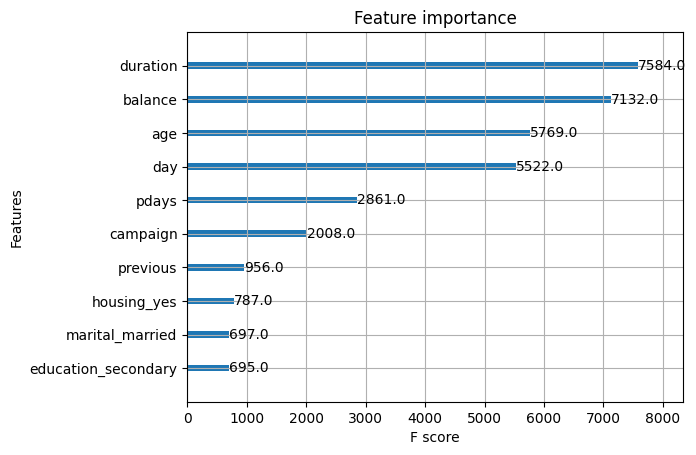

In [65]:
xgb.plot_importance(model_final, max_num_features=10)

In [67]:
explainer = shap.TreeExplainer(model_final)
shap_values = explainer.shap_values(X_test)

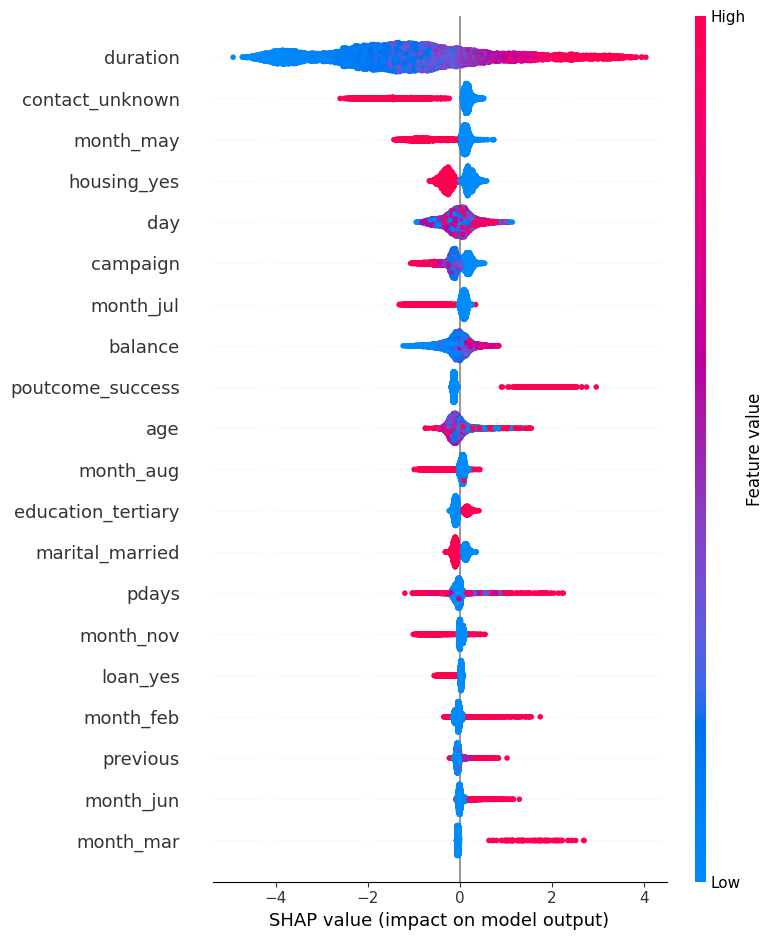

In [69]:
shap.summary_plot(shap_values, X_test, feature_names=feature_col)